In [27]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
import plotly_express as px


# Para el modelado de los datos
# -----------------------------------------------------------------------
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering

# Importar nuestro archivo de soporte
# -----------------------------------------------------------------------
import sys
sys.path.append('..') #pongo los 2 puntos para que salga de la carpeta
from src import soporte_clustering as sc
from src import funciones as f
from src import soporte_prep as spp
from src import soporte_encoding as se
# Para visualizar los dendrogramas
# -----------------------------------------------------------------------
import scipy.cluster.hierarchy as sch
# Configuración warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')
import math

pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
df = pd.read_csv('../Datos/Global_Superstore.csv', encoding='latin')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,31-07-2012,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,"10,024.00",US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,"2,309.65",7,0.00,762.18,933.57,Critical
1,26341,IN-2013-77878,05-02-2013,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","3,709.39",9,0.10,-288.76,923.63,Critical
2,25330,IN-2013-71249,17-10-2013,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID","5,175.17",9,0.10,919.97,915.49,Medium
3,13524,ES-2013-1579342,28-01-2013,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless","2,892.51",5,0.10,-96.54,910.16,Medium
4,47221,SG-2013-4320,05-11-2013,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed","2,832.96",8,0.00,311.52,903.04,Critical


In [29]:
df['Order Date'] = pd.to_datetime(df['Order Date'], format='%d-%m-%Y')


In [30]:
df['Order Date'].describe()

count                            51290
mean     2013-05-11 21:26:49.155781120
min                2011-01-01 00:00:00
25%                2012-06-19 00:00:00
50%                2013-07-08 00:00:00
75%                2014-05-22 00:00:00
max                2014-12-31 00:00:00
Name: Order Date, dtype: object

In [31]:
df[df['Customer Name'] == 'Seth Vernon'].head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
1273,37396,CA-2014-100111,2014-09-21,27-09-2014,Standard Class,SV-20365,Seth Vernon,Consumer,New York City,New York,United States,"10,035.00",US,East,FUR-CH-10004086,Furniture,Chairs,Hon 4070 Series Pagoda Armless Upholstered Sta...,"2,888.13",11,0.10,609.72,177.06,Medium
1303,37398,CA-2014-100111,2014-09-21,27-09-2014,Standard Class,SV-20365,Seth Vernon,Consumer,New York City,New York,United States,"10,035.00",US,East,FUR-CH-10001215,Furniture,Chairs,Global Troy Executive Leather Low-Back Tilter,"2,254.41",5,0.10,375.74,175.20,Medium
2134,36372,CA-2011-134572,2011-04-20,22-04-2011,Second Class,SV-20365,Seth Vernon,Consumer,Houston,Texas,United States,"77,070.00",US,Central,FUR-TA-10001705,Furniture,Tables,Bush Advantage Collection Round Conference Table,744.10,5,0.30,-95.67,128.29,High
2271,39666,CA-2013-118745,2013-06-12,17-06-2013,Standard Class,SV-20365,Seth Vernon,Consumer,Los Angeles,California,United States,"90,049.00",US,West,FUR-TA-10003473,Furniture,Tables,Bretford Rectangular Conference Table Tops,902.71,3,0.20,33.85,123.06,High
3391,17235,ES-2014-2606695,2014-07-03,03-07-2014,Same Day,SV-20365,Seth Vernon,Consumer,Middlesbrough,England,United Kingdom,NaN,EU,North,TEC-PH-10002255,Technology,Phones,"Apple Audio Dock, Full Size",672.72,4,0.00,60.48,90.65,High


In [32]:
df[df['Customer Name'] == 'Seth Vernon']['Order Priority'].value_counts()

Order Priority
Medium      55
High        22
Critical     7
Low          1
Name: count, dtype: int64

A través de algunos filtros, pude darme cuenta de que tenía desglosados los pedidos individuales de cada persona. Esto es la vez corresponde a pedidos que se asignan a una factura en particular, por lo que es posible encontrarse con la misma persona varias veces pero donde hace pedidos de una cantidad de artículos en particular, que estos pueden unirse a otros y que además se acumulan a las distintas facturas de una persona. Como lo muestro arriba y abajo de este comentario.

In [33]:
df[df['Customer Name'] == 'Seth Vernon']['Order ID'].unique()

array(['CA-2014-100111', 'CA-2011-134572', 'CA-2013-118745',
       'ES-2014-2606695', 'IN-2012-63080', 'SA-2012-4180',
       'CA-2012-168746', 'US-2012-100930', 'IN-2014-70507',
       'ES-2013-2023938', 'CA-2012-8480', 'IN-2013-77528',
       'US-2012-139843', 'ID-2011-36333', 'ID-2014-20058',
       'MX-2011-156349', 'CA-2014-159793', 'US-2014-165358',
       'US-2012-116288', 'ES-2011-3856710', 'CA-2014-161200',
       'ID-2011-29368', 'MX-2012-130603', 'US-2013-136581',
       'ID-2013-12442', 'IS-2014-7950', 'MX-2013-108133',
       'CA-2013-157511', 'ID-2012-53749', 'IN-2014-26106',
       'CA-2011-130092', 'HU-2012-9490', 'TU-2013-3390', 'ID-2013-33197',
       'MX-2014-122567', 'IN-2012-78984'], dtype=object)

In [34]:
preprocesar = sc.Exploracion(df)
preprocesar.explorar_datos()

5 registros aleatorios:


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
35397,42193,IZ-2013-9760,2013-06-26,30-06-2013,Standard Class,CA-2055,Cathy Armstrong,Home Office,Mosul,Ninawa,Iraq,NaN,EMEA,EMEA,OFF-STA-10001112,Office Supplies,Art,"Stanley Markers, Easy-Erase",134.82,6,0.00,0.00,3.47,High
49540,34744,CA-2014-102554,2014-06-12,16-06-2014,Standard Class,KN-16705,Kristina Nunn,Home Office,Auburn,Alabama,United States,"36,830.00",US,South,OFF-AR-10001919,Office Supplies,Art,"OIC #2 Pencils, Medium Soft",3.76,2,0.00,1.09,0.45,High
7800,39952,CA-2011-142769,2011-09-13,13-09-2011,Same Day,RP-19390,Resi Pölking,Consumer,Seattle,Washington,United States,"98,103.00",US,West,TEC-AC-10000865,Technology,Accessories,WD My Passport Ultra 500GB Portable External H...,118.00,2,0.00,20.06,43.41,High
13092,6336,MX-2011-137603,2011-08-04,08-08-2011,Standard Class,SH-20395,Shahid Hopkins,Consumer,Nicolás Romero,México,Mexico,NaN,LATAM,North,TEC-MA-10001403,Technology,Machines,"Panasonic Calculator, White",129.84,4,0.00,38.88,23.76,High
31163,37418,CA-2014-143378,2014-09-20,26-09-2014,Standard Class,JR-16210,Justin Ritter,Corporate,Springfield,Oregon,United States,"97,477.00",US,West,FUR-BO-10001972,Furniture,Bookcases,O'Sullivan 4-Shelf Bookcase in Odessa Pine,72.59,2,0.70,-128.24,5.00,Medium




Información general del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  object        
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      5

,count,mean,min,25%,50%,75%,max,std
Row ID,"51,290.00","25,645.50",1.00,"12,823.25","25,645.50","38,467.75","51,290.00","14,806.29"
Order Date,51290,2013-05-11 21:26:49.155781120,2011-01-01 00:00:00,2012-06-19 00:00:00,2013-07-08 00:00:00,2014-05-22 00:00:00,2014-12-31 00:00:00,NaN
Postal Code,"9,994.00","55,190.38","1,040.00","23,223.00","56,430.50","90,008.00","99,301.00","32,063.69"
Sales,"51,290.00",246.49,0.44,30.76,85.05,251.05,"22,638.48",487.57
Quantity,"51,290.00",3.48,1.00,2.00,3.00,5.00,14.00,2.28
Discount,"51,290.00",0.14,0.00,0.00,0.00,0.20,0.85,0.21
Profit,"51,290.00",28.61,"-6,599.98",0.00,9.24,36.81,"8,399.98",174.34
Shipping Cost,"51,290.00",26.38,0.00,2.61,7.79,24.45,933.57,57.30




Estadísticas descriptivas de las columnas categóricas:


,count,unique,top,freq
Order ID,51290,25035,CA-2014-100111,14
Ship Date,51290,1464,22-11-2014,130
Ship Mode,51290,4,Standard Class,30775
Customer ID,51290,1590,PO-18850,97
Customer Name,51290,795,Muhammed Yedwab,108
Segment,51290,3,Consumer,26518
City,51290,3636,New York City,915
State,51290,1094,California,2001
Country,51290,147,United States,9994
Market,51290,7,APAC,11002




Número de valores nulos por columna:
Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64


Distribución de valores categóricos:

Columna: Order ID
Order ID
CA-2014-100111    14
NI-2014-8880      13
TO-2014-9950      13
IN-2012-41261     13
IN-2013-42311     13
                  ..
ID-2014-68085      1
ID-2012-85221      1
CA-2012-119697     1
CA-2011-151967     1
MX-2012-134460     1
Name: count, Length: 25035, dtype: int64

Columna: Ship Date
Ship Date
22-

,Row ID,Postal Code,Sales,Quantity,Discount,Profit,Shipping Cost
Row ID,1.00,0.01,-0.04,-0.17,0.09,-0.02,-0.04
Postal Code,0.01,1.00,-0.02,0.01,0.06,-0.03,-0.03
Sales,-0.04,-0.02,1.00,0.31,-0.09,0.48,0.77
Quantity,-0.17,0.01,0.31,1.00,-0.02,0.10,0.27
Discount,0.09,0.06,-0.09,-0.02,1.00,-0.32,-0.08
Profit,-0.02,-0.03,0.48,0.10,-0.32,1.00,0.35
Shipping Cost,-0.04,-0.03,0.77,0.27,-0.08,0.35,1.00


## EDA

Observaciones:
- Tenemos nulos solamente en una columna (Postal Code)
- No tenemos duplicados
- No hay muchas correlaciones evidentes entre las columnas numéricas pero sí se observa:
    ** Sales-Shipping Cost (0.76)**
    **  Profit-Sales (0.48) **
- Estamos manejando unos datos que corresponden a órdenes de pedidos desde el primer día del 2011 hasta el último día deel 2014 (1 de enero a 31 de diciembre)

In [35]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Postal Code', 'Market', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping Cost', 'Order Priority'],
      dtype='object')

In [36]:
df_copy = df.copy()

Me he cargado la columna de código postal porque es la única que tiene nulos, además de que tiene una gran cantidad de nulos. Las demás columnas tampoco son tan importantes para mi abordaje.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          51290 non-null  int64         
 1   Order ID        51290 non-null  object        
 2   Order Date      51290 non-null  datetime64[ns]
 3   Ship Date       51290 non-null  object        
 4   Ship Mode       51290 non-null  object        
 5   Customer ID     51290 non-null  object        
 6   Customer Name   51290 non-null  object        
 7   Segment         51290 non-null  object        
 8   City            51290 non-null  object        
 9   State           51290 non-null  object        
 10  Country         51290 non-null  object        
 11  Postal Code     9994 non-null   float64       
 12  Market          51290 non-null  object        
 13  Region          51290 non-null  object        
 14  Product ID      51290 non-null  object        
 15  Ca

In [38]:
df.nunique()

Row ID            51290
Order ID          25035
Order Date         1430
Ship Date          1464
Ship Mode             4
Customer ID        1590
Customer Name       795
Segment               3
City               3636
State              1094
Country             147
Postal Code         631
Market                7
Region               13
Product ID        10292
Category              3
Sub-Category         17
Product Name       3788
Sales             22995
Quantity             14
Discount             27
Profit            24575
Shipping Cost     10037
Order Priority        4
dtype: int64

De la siguiente manera me di cuenta que existe un caso muy particular, una misma persona corresponde a distintos países diferentes en sus pedidos. Esto a la vez hace que corresponda a una region distinta, y un mercado distinto. Por ende decidí agrupar mis datos directamente por los clientes individuales.

In [39]:
df[df['Customer Name'] == 'Aaron Bergman']['Country'].value_counts()

Country
Australia         10
Italy              7
Germany            6
Indonesia          6
India              6
Thailand           6
United States      6
France             5
United Kingdom     4
Ukraine            4
Zambia             4
Mexico             3
Vietnam            3
Brazil             3
Iran               2
Cameroon           2
Guatemala          2
China              2
Netherlands        2
Nicaragua          2
El Salvador        2
Argentina          2
Name: count, dtype: int64

In [40]:
df.groupby('Customer Name')['Sales'].sum()

Customer Name
Aaron Bergman        24,644.63
Aaron Hawkins        20,759.51
Aaron Smayling       14,212.63
Adam Bellavance      20,186.78
Adam Hart            21,718.20
                        ...   
Xylona Preis         12,198.95
Yana Sorensen        20,032.44
Yoseph Carroll       20,164.38
Zuschuss Carroll     28,479.99
Zuschuss Donatelli   12,430.57
Name: Sales, Length: 795, dtype: float64

In [41]:
df.groupby('Customer Name')['Discount'].mean()

Customer Name
Aaron Bergman        0.11
Aaron Hawkins        0.16
Aaron Smayling       0.17
Adam Bellavance      0.13
Adam Hart            0.09
                     ... 
Xylona Preis         0.08
Yana Sorensen        0.07
Yoseph Carroll       0.07
Zuschuss Carroll     0.22
Zuschuss Donatelli   0.12
Name: Discount, Length: 795, dtype: float64

In [42]:
df.groupby("Customer Name")[["Discount","Profit"]].agg(["mean","sum"])

Discount       Profit         
                       mean   sum   mean      sum
Customer Name                                    
Aaron Bergman          0.11  9.80  52.62 4,683.21
Aaron Hawkins          0.16  9.01  43.77 2,450.93
Aaron Smayling         0.17 10.06   6.15   369.16
Adam Bellavance        0.13  8.96  73.23 4,979.98
Adam Hart              0.09  7.83  22.64 1,902.03
...                     ...   ...    ...      ...
Xylona Preis           0.08  5.17  21.39 1,304.72
Yana Sorensen          0.07  4.40  55.65 3,450.41
Yoseph Carroll         0.07  3.92  77.63 4,347.18
Zuschuss Carroll       0.22 18.81   5.14   436.94
Zuschuss Donatelli     0.12  6.25   3.74   201.74

[795 rows x 4 columns]

In [43]:
df.groupby("Customer Name")[["Discount","Sales"]].agg({"Discount":"mean","Sales":"sum"})

,Discount,Sales
Customer Name,,
Aaron Bergman,0.11,"24,644.63"
Aaron Hawkins,0.16,"20,759.51"
Aaron Smayling,0.17,"14,212.63"
Adam Bellavance,0.13,"20,186.78"
Adam Hart,0.09,"21,718.20"
...,...,...
Xylona Preis,0.08,"12,198.95"
Yana Sorensen,0.07,"20,032.44"
Yoseph Carroll,0.07,"20,164.38"


In [44]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,Market,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2012-124891,2012-07-31,31-07-2012,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,United States,"10,024.00",US,East,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,"2,309.65",7,0.00,762.18,933.57,Critical
1,26341,IN-2013-77878,2013-02-05,07-02-2013,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,Australia,NaN,APAC,Oceania,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black","3,709.39",9,0.10,-288.76,923.63,Critical
2,25330,IN-2013-71249,2013-10-17,18-10-2013,First Class,CR-12730,Craig Reiter,Consumer,Brisbane,Queensland,Australia,NaN,APAC,Oceania,TEC-PH-10004664,Technology,Phones,"Nokia Smart Phone, with Caller ID","5,175.17",9,0.10,919.97,915.49,Medium
3,13524,ES-2013-1579342,2013-01-28,30-01-2013,First Class,KM-16375,Katherine Murray,Home Office,Berlin,Berlin,Germany,NaN,EU,Central,TEC-PH-10004583,Technology,Phones,"Motorola Smart Phone, Cordless","2,892.51",5,0.10,-96.54,910.16,Medium
4,47221,SG-2013-4320,2013-11-05,06-11-2013,Same Day,RH-9495,Rick Hansen,Consumer,Dakar,Dakar,Senegal,NaN,Africa,Africa,TEC-SHA-10000501,Technology,Copiers,"Sharp Wireless Fax, High-Speed","2,832.96",8,0.00,311.52,903.04,Critical


### Conociendo mis datos

In [45]:
df.groupby(['Market', 'Region'])['Region'].count()

Market  Region        
APAC    Central Asia      2048
        North Asia        2338
        Oceania           3487
        Southeast Asia    3129
Africa  Africa            4587
Canada  Canada             384
EMEA    EMEA              5029
EU      Central           5822
        North             2141
        South             2037
LATAM   Caribbean         1690
        Central           2972
        North             2644
        South             2988
US      Central           2323
        East              2848
        South             1620
        West              3203
Name: Region, dtype: int64

De esta forma puedo conocer las regiones de mis mercados, para conocer exactamente lo que se mueve allí y el contenido de este. De igual forma, poder investigar las regiones dentro de cada una y los países.

In [46]:
pd.options.display.float_format = '{:,.2f}'.format

In [47]:
df.groupby('Market')['Sales'].sum()

Market
APAC     3,585,744.13
Africa     783,773.21
Canada      66,928.17
EMEA       806,161.31
EU       2,938,089.06
LATAM    2,164,605.17
US       2,297,200.86
Name: Sales, dtype: float64

Dos cosas importantes visualizadas: profit-sales, en 0.48% Y tener sales-shipping cost

In [48]:
df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')

df['Discount_Category'] = pd.cut(
    df['Discount'],
    bins=[-float('inf'), 0.250, 0.500, 0.750, float('inf')],  # Límites de las categorías
    labels=['< 0.250', '0.250 - 0.500', '0.500 - 0.750', '> 0.750']  # Nombres de las categorías
)

print(df[['Discount', 'Discount_Category']])

       Discount Discount_Category
0          0.00           < 0.250
1          0.10           < 0.250
2          0.10           < 0.250
3          0.10           < 0.250
4          0.00           < 0.250
...         ...               ...
51285      0.00           < 0.250
51286      0.80           > 0.750
51287      0.00           < 0.250
51288      0.00           < 0.250
51289      0.00           < 0.250

[51290 rows x 2 columns]


In [49]:
df['Quantity_Group'] = pd.cut(
    df['Quantity'],
    bins=[-float('inf'), 5, 10, 15],  # Límites de los grupos
    labels=['<= 5', '6 - 10', '11 - 15']  # Nombres de los grupos
)

# Ver los resultados
print(df[['Quantity', 'Quantity_Group']].head())


   Quantity Quantity_Group
0         7         6 - 10
1         9         6 - 10
2         9         6 - 10
3         5           <= 5
4         8         6 - 10


Convierto a categóricas las columnas de Quantity para hacer más fácil la categorización de las mismas.

In [50]:
df.drop(columns=['Discount', 'Quantity'], inplace=True)

Los descuentos se agrupan por debajo del 25% cerca del 80% de los pedidos.

La cantidad de artículos, se agrupan en un 83% para menos de 5 artículos.

In [51]:
df_copy.drop(columns=['Postal Code', 'Row ID', 'Product ID', 'Customer ID', 'Ship Date', 'City', 'State', 'Product Name', 'Order ID', 'Order Date'], inplace=True)

In [52]:
df_copy.head()

,Ship Mode,Customer Name,Segment,Country,Market,Region,Category,Sub-Category,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,Same Day,Rick Hansen,Consumer,United States,US,East,Technology,Accessories,"2,309.65",7,0.00,762.18,933.57,Critical
1,Second Class,Justin Ritter,Corporate,Australia,APAC,Oceania,Furniture,Chairs,"3,709.39",9,0.10,-288.76,923.63,Critical
2,First Class,Craig Reiter,Consumer,Australia,APAC,Oceania,Technology,Phones,"5,175.17",9,0.10,919.97,915.49,Medium
3,First Class,Katherine Murray,Home Office,Germany,EU,Central,Technology,Phones,"2,892.51",5,0.10,-96.54,910.16,Medium
4,Same Day,Rick Hansen,Consumer,Senegal,Africa,Africa,Technology,Copiers,"2,832.96",8,0.00,311.52,903.04,Critical


In [56]:
df_copy.describe()

,Sales,Quantity,Discount,Profit,Shipping Cost
count,"51,290.00","51,290.00","51,290.00","51,290.00","51,290.00"
mean,246.49,3.48,0.14,28.61,26.38
std,487.57,2.28,0.21,174.34,57.30
min,0.44,1.00,0.00,"-6,599.98",0.00
25%,30.76,2.00,0.00,0.00,2.61
50%,85.05,3.00,0.00,9.24,7.79
75%,251.05,5.00,0.20,36.81,24.45
max,"22,638.48",14.00,0.85,"8,399.98",933.57


In [53]:
preprocesar_cluster = sc.Exploracion(df_copy)

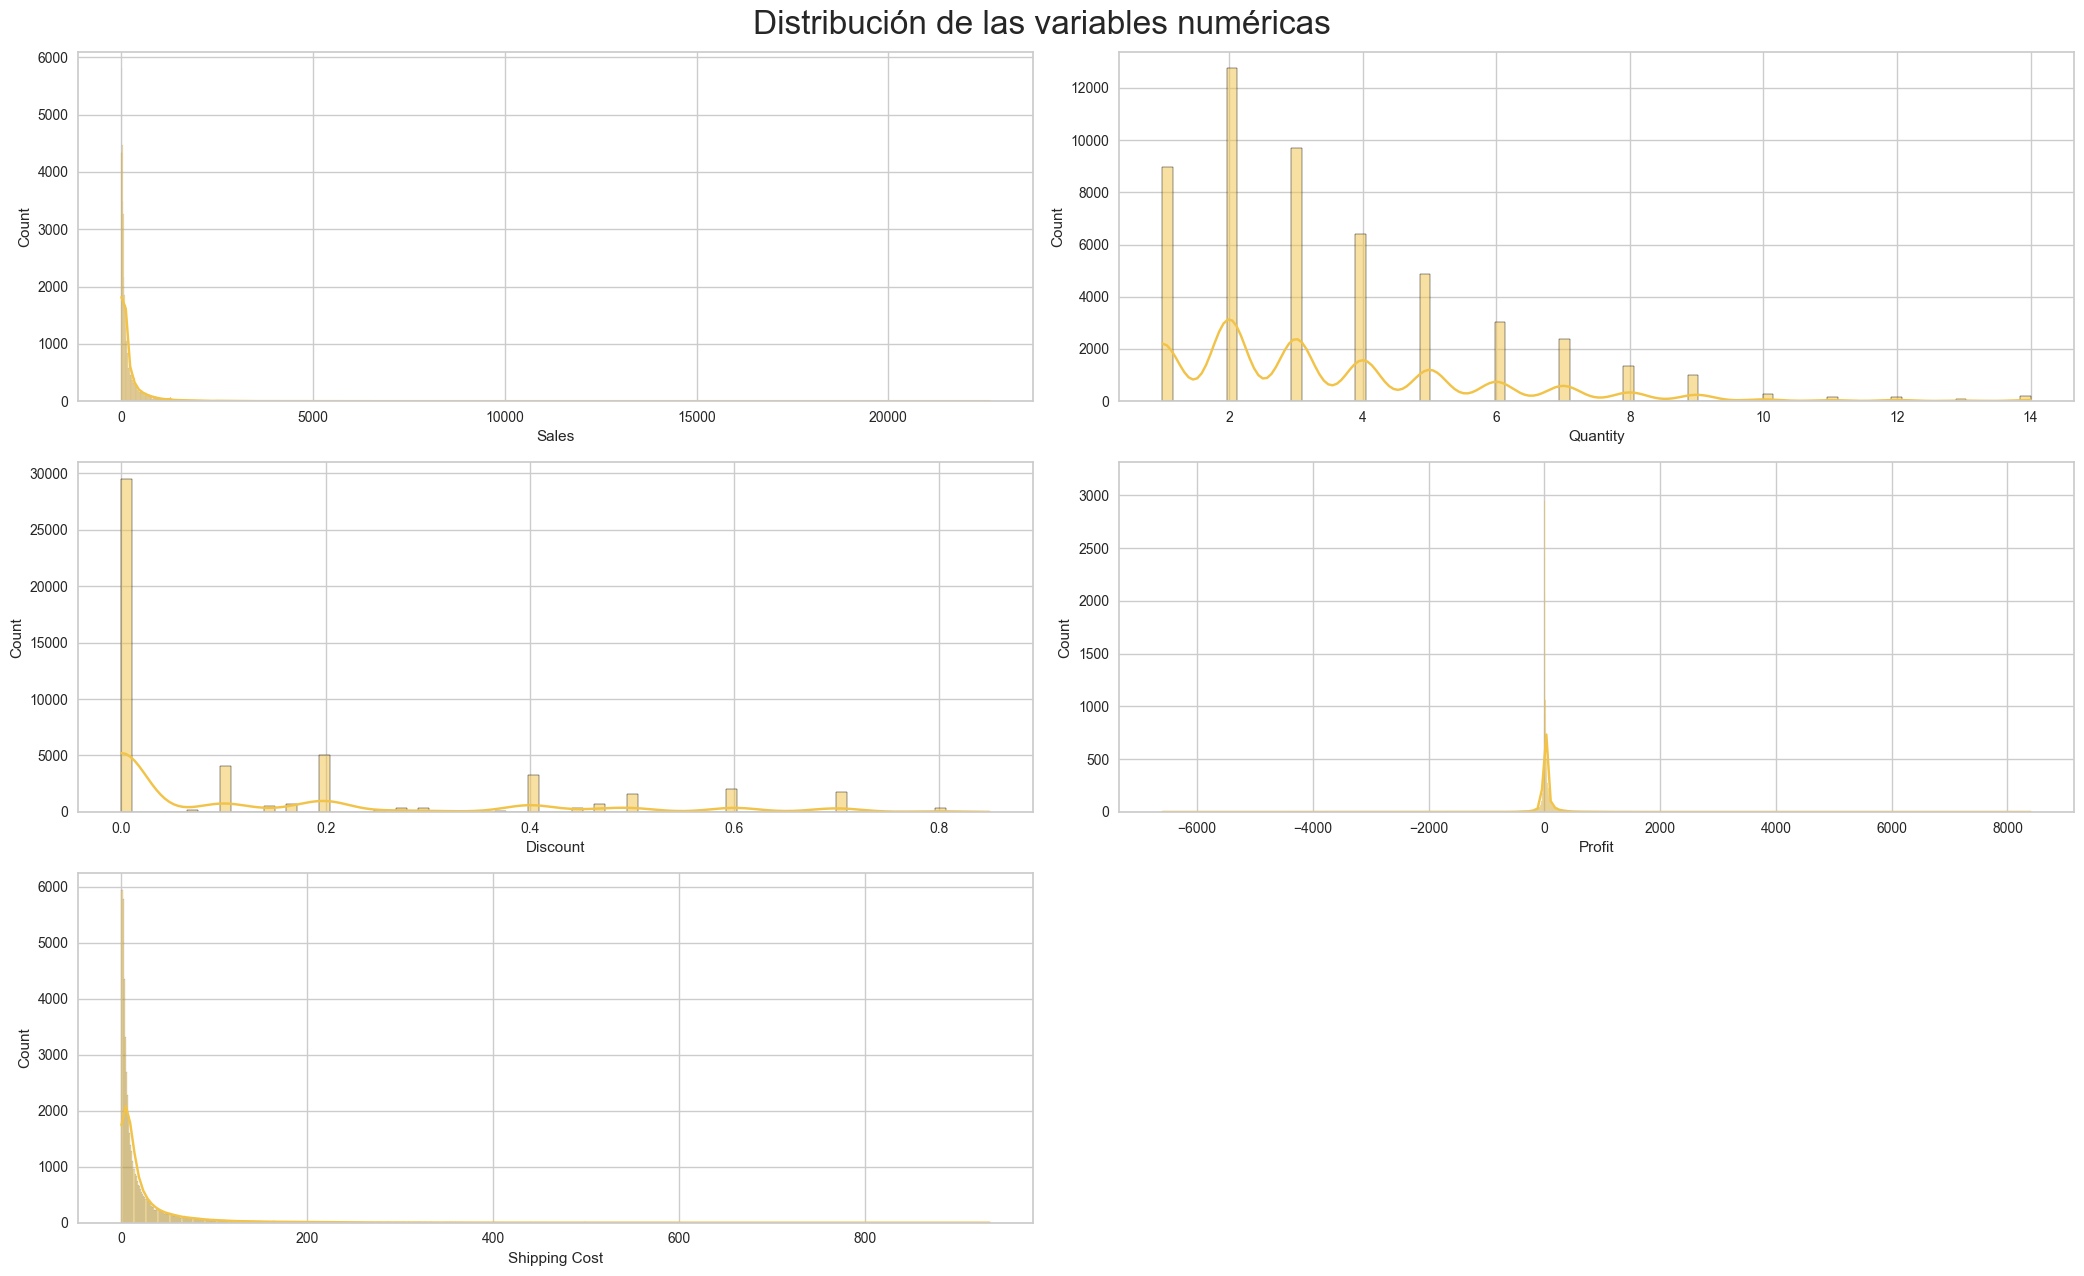

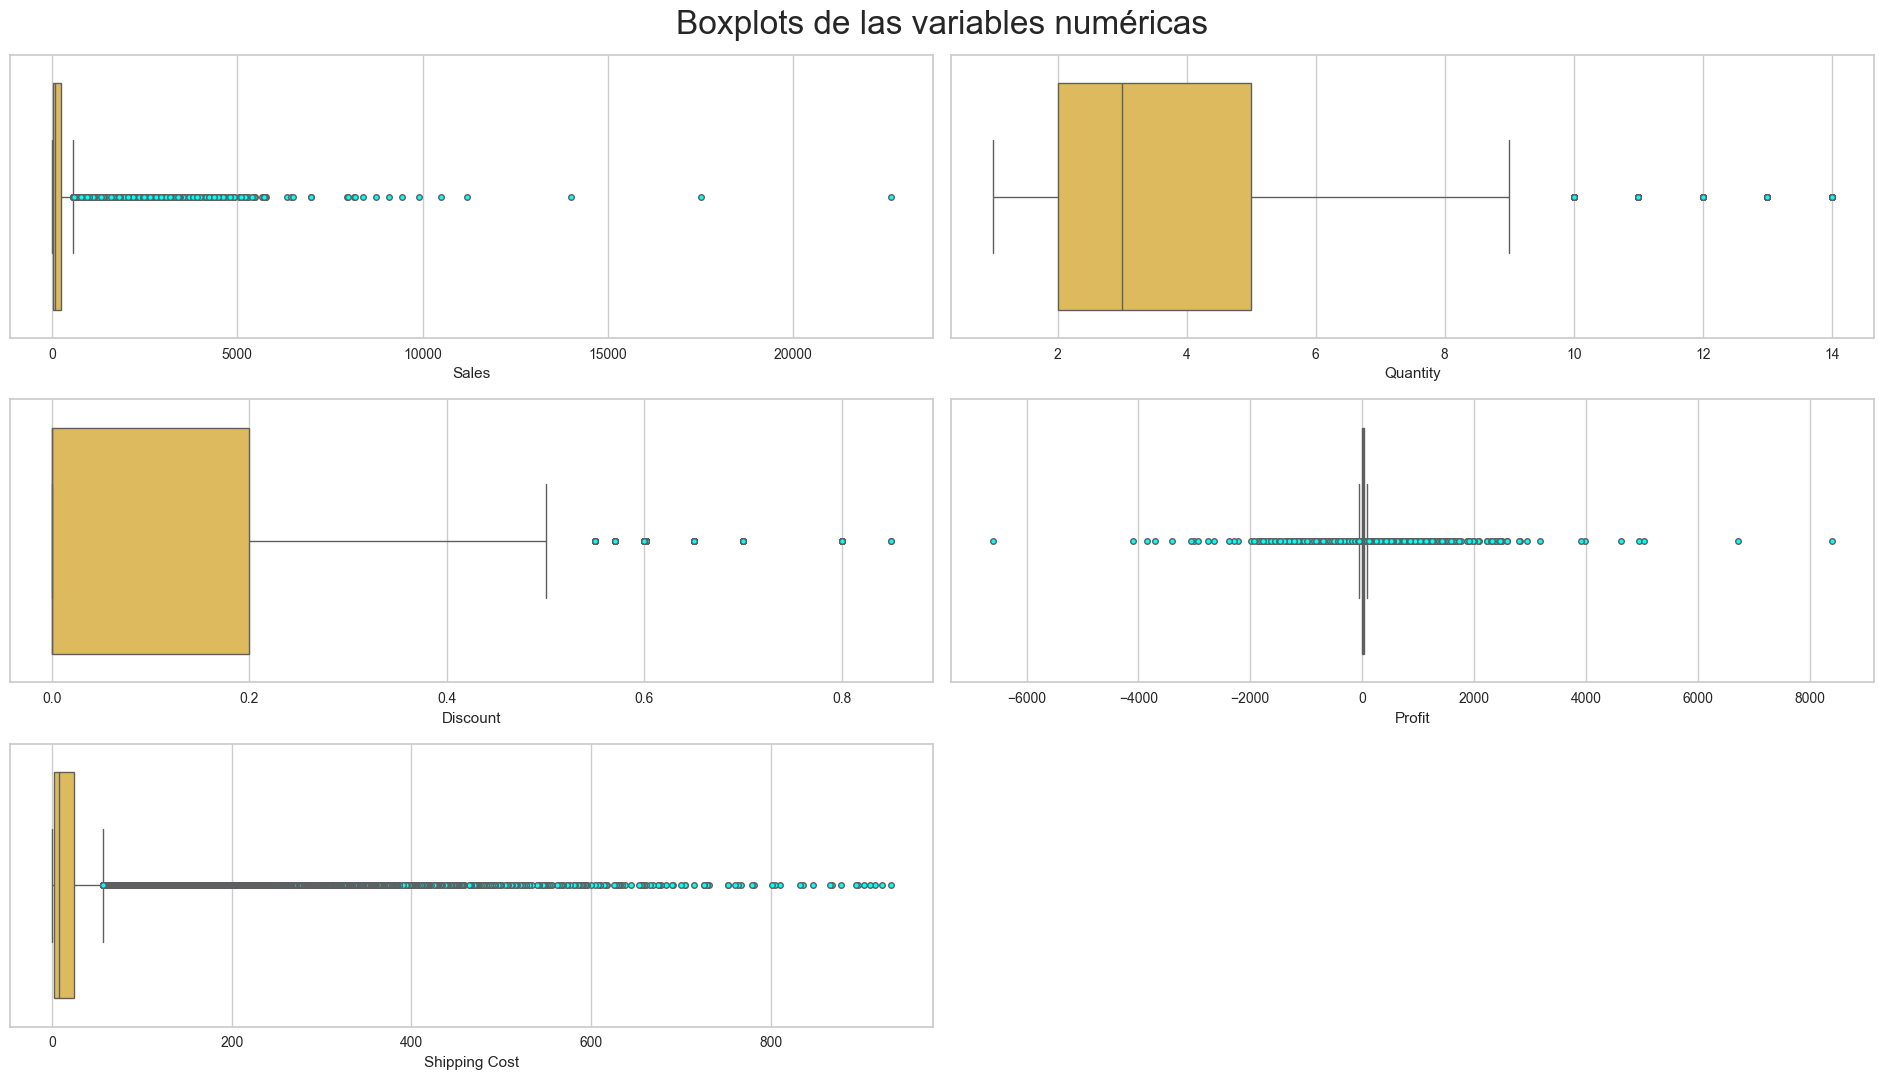

In [54]:
preprocesar_cluster.visualizar_numericas()

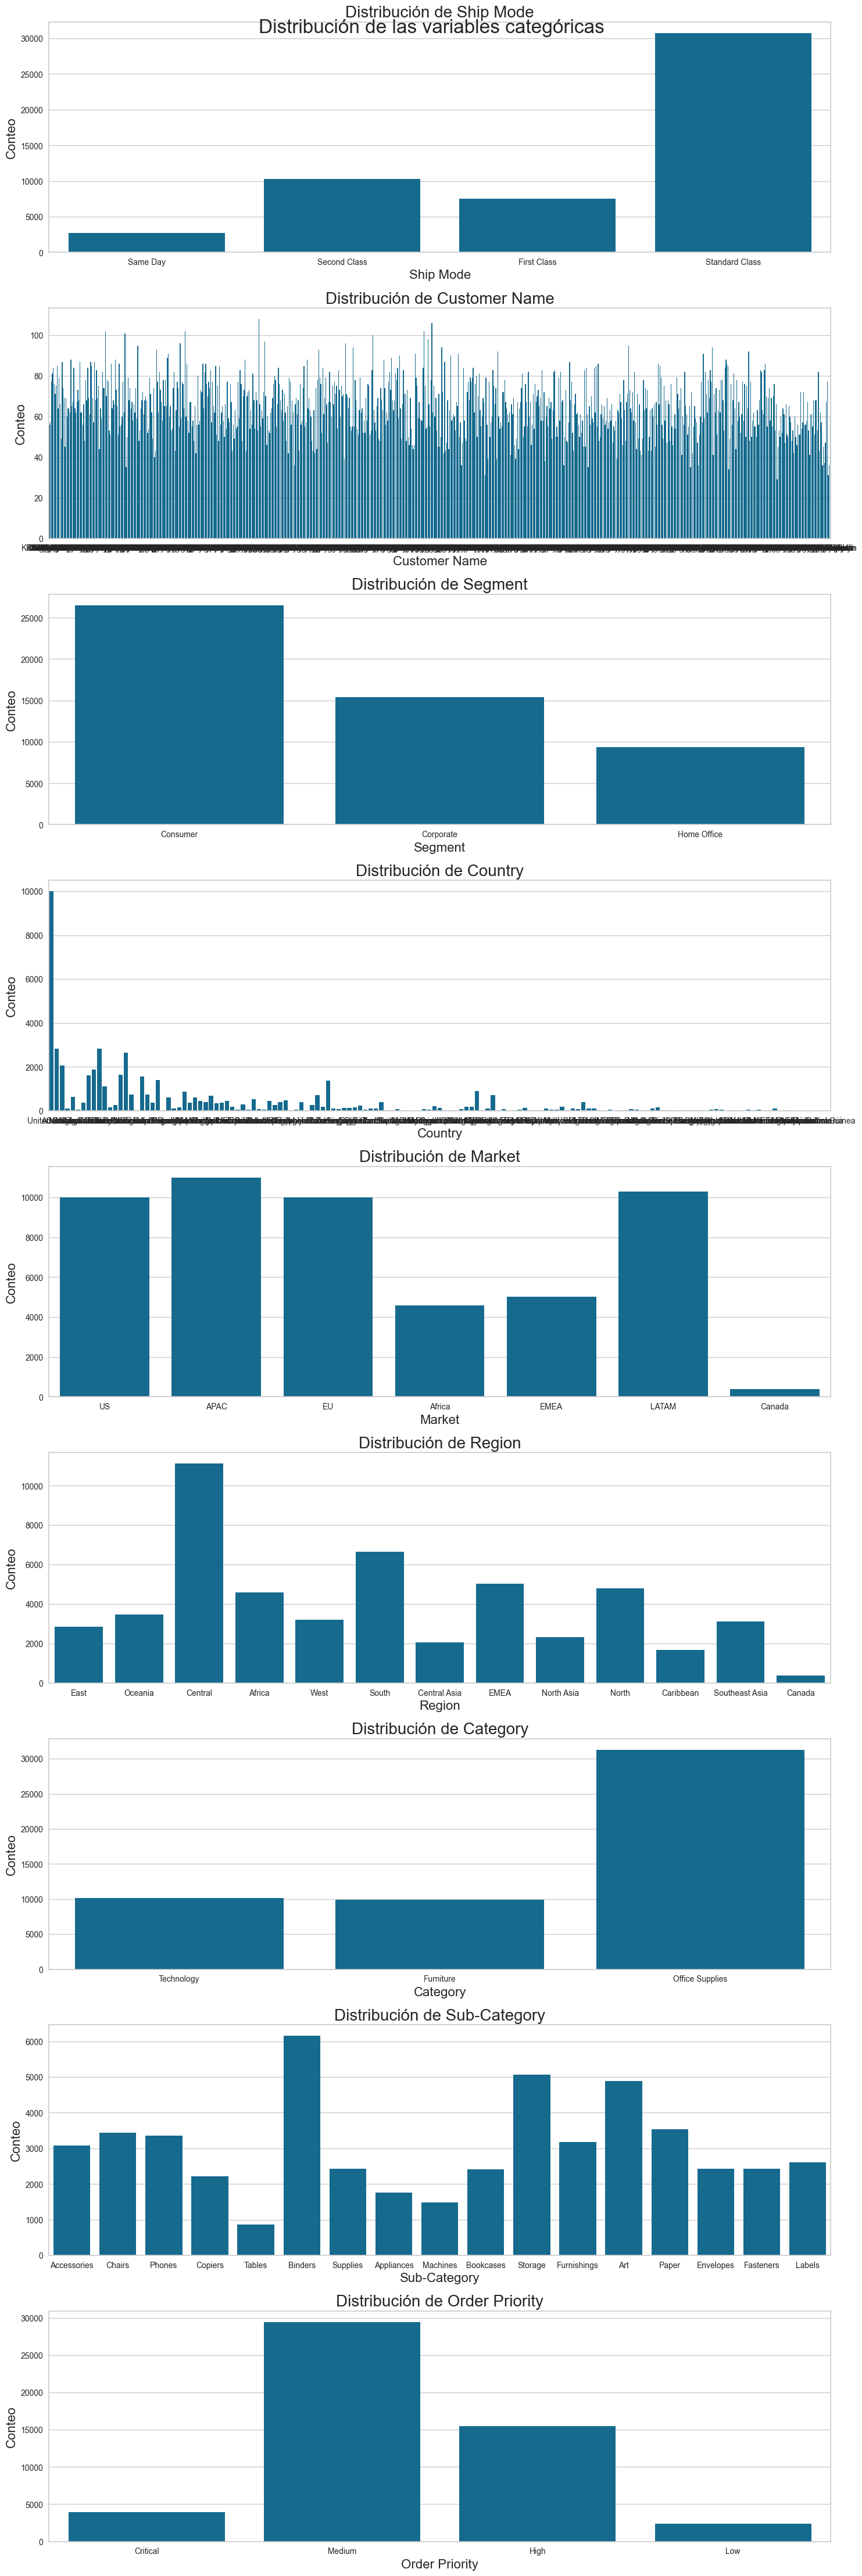

In [55]:
preprocesar_cluster.visualizar_categoricas()

## Data frame a clustorizar

In [ ]:
df_clustorizar = df.groupby("Customer Name")[["Order ID","Discount","Sales","Category", 'Profit', 'Shipping Cost']].agg(facturas_total=('Order ID', 'count'), descuento_medio=("Discount","mean"),compras_total=("Sales","sum"),compras_media=("Sales","mean"),categorias_compra=('Category', 'nunique'), beneficio_total=('Profit', 'sum'), costo_envio_medio=('Shipping Cost', 'mean'))

In [ ]:
df_clustorizar['categorias_compra'].value_counts()

categorias_compra
3    795
Name: count, dtype: int64

In [ ]:
df_clustorizar.describe()

,facturas_total,descuento_medio,compras_total,compras_media,categorias_compra,beneficio_total,costo_envio_medio
count,795.00,795.00,795.00,795.00,795.00,795.00,795.00
mean,64.52,0.14,"15,902.52",246.23,3.00,"1,845.86",26.35
std,13.43,0.05,"5,209.81",61.77,0.00,"1,544.34",7.44
min,29.00,0.05,"3,892.23",108.12,3.00,"-6,151.56",9.22
25%,55.00,0.11,"12,242.61",205.58,3.00,984.34,21.19
50%,64.00,0.14,"15,257.53",239.77,3.00,"1,788.72",25.27
75%,74.00,0.17,"18,770.80",278.52,3.00,"2,603.60",30.49
max,108.00,0.30,"40,488.07",703.42,3.00,"8,672.90",58.22


In [ ]:
visuales = spp.Visualizador(df_clustorizar)

In [ ]:
df_clustorizar.head()

,Quantity_Group,Sales,Discount_Category,Shipping Cost,Segment,Country,Market,Category,Order Priority,Sub-Category
0,6 - 10,"2,309.65",< 0.250,933.57,Consumer,United States,US,Technology,Critical,Accessories
1,6 - 10,"3,709.39",< 0.250,923.63,Corporate,Australia,APAC,Furniture,Critical,Chairs
2,6 - 10,"5,175.17",< 0.250,915.49,Consumer,Australia,APAC,Technology,Medium,Phones
3,<= 5,"2,892.51",< 0.250,910.16,Home Office,Germany,EU,Technology,Medium,Phones
4,6 - 10,"2,832.96",< 0.250,903.04,Consumer,Senegal,Africa,Technology,Critical,Copiers


## Escalar numéricas

In [ ]:
lista_col_num = df_cluster.select_dtypes(include=[int, float]).columns.tolist()